In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from model import MobileNetV2, ModelTrainer
import data
import isic2017
import gcapm
from pytorch_grad_cam import GradCAM
from metrics import CoverageMetrics
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

In [2]:
# to reproduce
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
batch_size = 32
img_size = (224, 224)
num_class = 3
df = isic2017.get_dataset("test")
dataloader = data.get_dataloader(df, img_size, batch_size, eval=False)

best_val_file = "../../dataset/SafeExplain/mobile/model_46.pt"
model = MobileNetV2(num_class)
model.load_state_dict(torch.load(best_val_file))

/tmp/ipykernel_475234/497488120.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_val_file))


<All keys matched successfully>

In [4]:
out_filepath = "../../dataset/SafeExplain/reports/mobile_model.csv"
eval = ModelTrainer()
preds, outputs = eval.evaluate(model, dataloader, out_filepath)

              precision    recall  f1-score     support
0              0.786543  0.862595  0.822816  393.000000
1              0.622222  0.239316  0.345679  117.000000
2              0.532258  0.733333  0.616822   90.000000
accuracy       0.721667  0.721667  0.721667    0.721667
macro avg      0.647008  0.611748  0.595106  600.000000
weighted avg   0.716358  0.721667  0.698875  600.000000


In [5]:
df["preds"] = preds
df_outputs = pd.DataFrame(outputs, columns=["proba_0", "proba_1", "proba_2"])
df = pd.concat([df, df_outputs], axis=1)
df["proba"] = df.apply(lambda row: row[f"proba_{row['label']}"], axis=1)

In [7]:
exp = {}

class_indices = [i for i in range(num_class)]
target_layers = [model.base_model.features[18][0]]

for inputs, labels, image_ids in dataloader:
    for i, single_image in enumerate(inputs):
        single_image = single_image.unsqueeze(0)  # (3, 224, 224) → (1, 3, 224, 224)
        cam_extractor = GradCAM(model=model, target_layers=target_layers)
        cams_softmax, cams = gcapm.multi_class_cam_correlation(cam_extractor, single_image, class_indices)
        max_class_indices = gcapm.get_max_class_per_pixel(cams_softmax)
        exp[image_ids[i]] = max_class_indices

In [8]:
cov = []
err = []
iou = []
for _, row in df.iterrows():
    label = row["label"]
    ground_truth = Image.open(row["segpath"])
    transform = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor(),])
    ground_truth = transform(ground_truth)
    ground_truth = ground_truth.squeeze(0).flatten().numpy()
    
    preds = exp[row["image_id"]]
    preds = preds.squeeze(0).squeeze(0).flatten().numpy()
    preds = np.where(preds == label, 1, 0)
    coverage = CoverageMetrics(ground_truth, preds)
    cov.append(coverage.sensitivity())
    err.append(coverage.false_positive_rate())
    iou.append(coverage.intersection_over_union())

In [14]:
df["Sensitivity"] = cov
df["FPR"] = err
df["IoU"] = iou

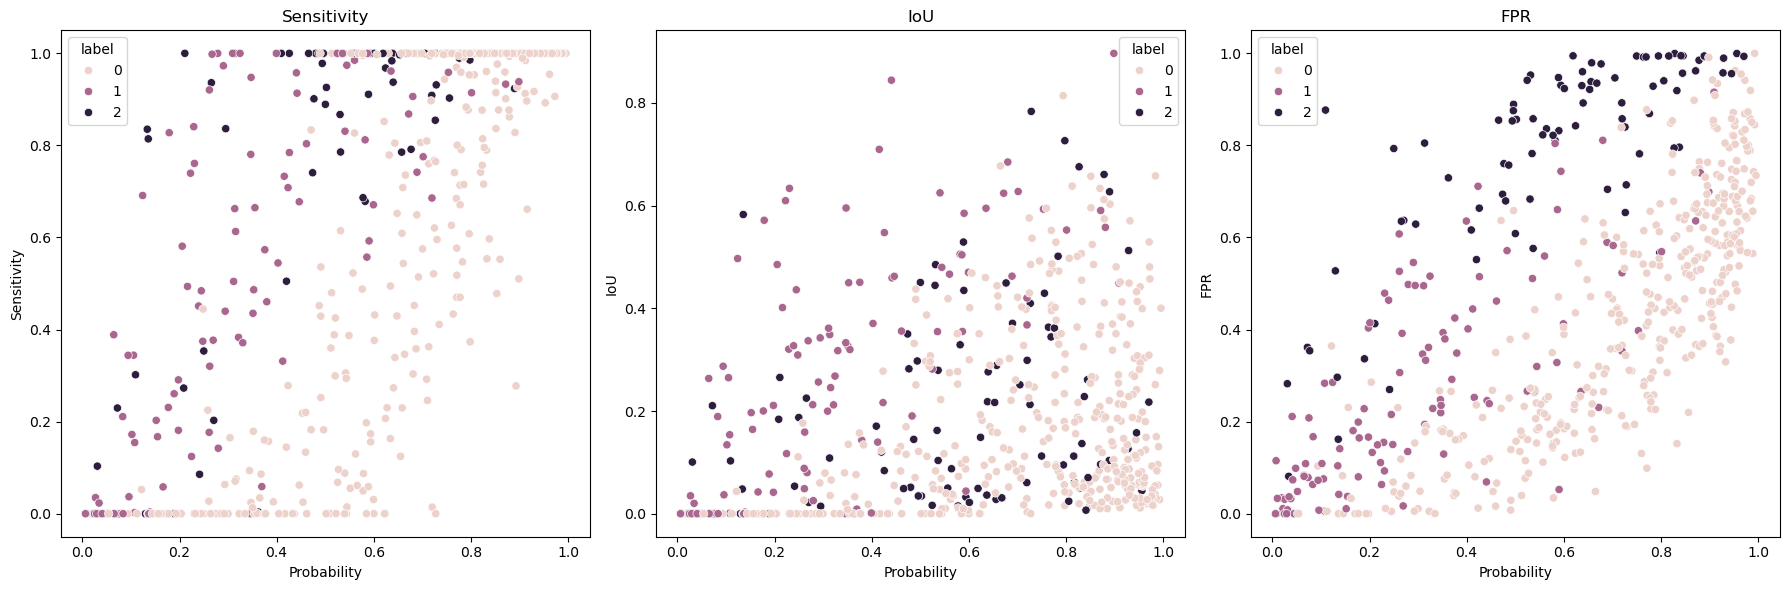

In [21]:
y_vars = ["Sensitivity", "IoU", "FPR"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

for ax, y_var in zip(axes, y_vars):
    sns.scatterplot(data=df, x="proba", y=y_var, hue="label", ax=ax)
    ax.set_title(y_var)
    ax.set_xlabel("Probability")
    ax.set_ylabel(y_var)

plt.tight_layout()
plt.show()

In [24]:
df[["proba", "Sensitivity", "FPR", "IoU"]].corr()

,proba,Sensitivity,FPR,IoU
proba,1.000000,0.748600,0.643067,0.207516
Sensitivity,0.748600,1.000000,0.674087,0.335706
FPR,0.643067,0.674087,1.000000,0.130589
IoU,0.207516,0.335706,0.130589,1.000000
